The following steps are necessary to download Kaggle dataset.

Firstly create a Kaggle API file that will be uploaded for account verification after installing kaggle module.

Download the dataset and then unzip it to see the contents.

In [1]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d tentotheminus9/gravity-spy-gravitational-waves

In [5]:
!unzip -q /content/gravity-spy-gravitational-waves.zip

In [6]:
!zip -r /content/test_data.zip /content/test/test

In [ ]:
'''
importing the required modules for the project
'''
import numpy as np
import pandas as pd

# plotting python modules
import matplotlib.pyplot as plt
import seaborn as sns

# modules helping to work with files and their paths
import os
import re

# modules for image processing
import cv2

# modules for creating neural network pipelines
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# modules for evaluation
from sklearn.metrics import confusion_matrix, classification_report

# modules for balancing unbalanced classes
import collections

The folders in Gravity Spy are divided on the basis of their respective categories. Counting the number of subdirectories in the train folder would give the number of categories the images are divided into.

In [ ]:
dir_path = r"/content/train/train"   # root directory declaration
folder_names = []         # list to append the names of individual categories
folder_count = 0         # count initialization to zero
'''
The below code works as -
It goes through each and every folder of the root directory. This gives the number of categories present using the count variable and also outputs a list containing all the
category names.
'''
for path in os.listdir(dir_path):
    if os.path.isdir(os.path.join(dir_path, path)):
        folder_count += 1
        folder_names.append(path)

print("The number of categories in Gravity Spy dataset: ", folder_count)
print("The categories are as: ", folder_names)

The number of categories in Gravity Spy dataset:  22
The categories are as:  ['Whistle', 'No_Glitch', 'Chirp', '1400Ripples', '1080Lines', 'Extremely_Loud', 'Low_Frequency_Lines', 'Scattered_Light', 'Repeating_Blips', 'Air_Compressor', 'Light_Modulation', 'Power_Line', 'None_of_the_Above', 'Tomte', 'Blip', 'Wandering_Line', 'Scratchy', 'Violin_Mode', 'Low_Frequency_Burst', 'Paired_Doves', 'Koi_Fish', 'Helix']


The following code gives the names of the categories and the number of images that are present in each of the categories in a cumulative format. To get the number of images in each category, subtract the previous number by the current number.

In [ ]:
categories = []             # the list is same as folder_names as declared above but used for this particular use case
img_counter = 0                # universal counter that does not reset when the subfolder name changes.
subfolder_counter = []           # list declared to store the count after it encounters the last image in a particular category based folder
for name in range(len(folder_names)):
    subfolder_path = os.path.join(dir_path, folder_names[name])         # joins the root directory path with the name of the category
    categories.append(folder_names[name])
    for img in os.listdir(subfolder_path):
        if img.endswith(".png"):            # all images in this project are stored as png files, hence this condition has been defined to avoid files with non .png endings
            img_counter += 1
    subfolder_counter.append(img_counter)       # will store the counter value when the last image of a particular folder is encountered
print(subfolder_counter)
print(categories)

[832, 1260, 1424, 1660, 2576, 3840, 5100, 6332, 7072, 7236, 8680, 9936, 10164, 10456, 15552, 15668, 16616, 17752, 19500, 19576, 21568, 22348]
['Whistle', 'No_Glitch', 'Chirp', '1400Ripples', '1080Lines', 'Extremely_Loud', 'Low_Frequency_Lines', 'Scattered_Light', 'Repeating_Blips', 'Air_Compressor', 'Light_Modulation', 'Power_Line', 'None_of_the_Above', 'Tomte', 'Blip', 'Wandering_Line', 'Scratchy', 'Violin_Mode', 'Low_Frequency_Burst', 'Paired_Doves', 'Koi_Fish', 'Helix']


In [ ]:
'''
The following code subtracts the consecutive count values to give the number of images present in a particular category.
The number obtained after subtraction is stored in a list which will help to determine class imbalance.
'''
total_imgs = []
total_imgs.append(subfolder_counter[0])
for i in range(len(subfolder_counter)-1):
    sub = subfolder_counter[i+1] - subfolder_counter[i]
    total_imgs.append(sub)
print(total_imgs)
print(len(total_imgs))

[832, 428, 164, 236, 916, 1264, 1260, 1232, 740, 164, 1444, 1256, 228, 292, 5096, 116, 948, 1136, 1748, 76, 1992, 780]
22


Plotting information helps to assess the nuances in the data. Barplot would be a perfect fit in cases where the count of a certain category needs to be found. Visual representations also help to understand the differences in an easier manner.


The following plot depicts that the dataset is highly imbalanced with most number of images in **Blip** category. Which is more than twice the second placed **Koi_Fish** category, closely followed by **Low_Frequency_Burst**.

The least amount of images in a particular category can be found in **Paired_Doves, Wandering_Lines, Air_Compressor and Chirp**.

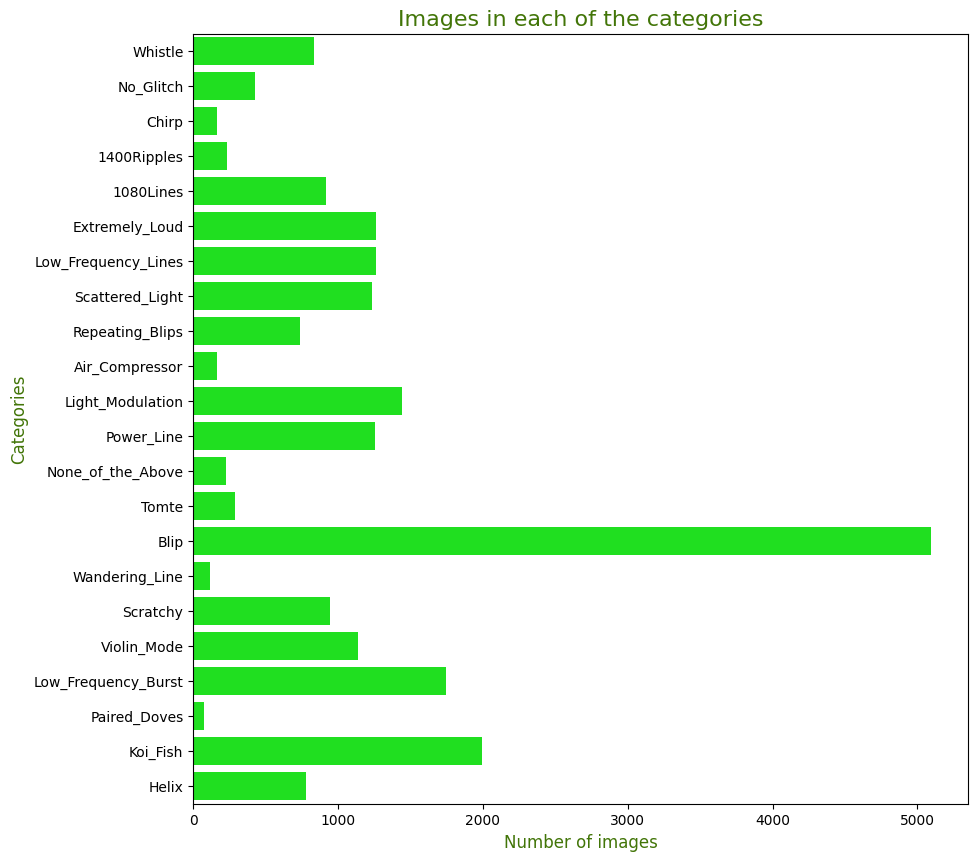

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x = total_imgs, y = categories, color = 'lime')
plt.title("Images in each of the categories", color = '#427508', fontsize = 16)
plt.xlabel("Number of images", color = '#427508', fontsize = 12)
plt.ylabel("Categories", color = '#427508', fontsize = 12)
plt.show()

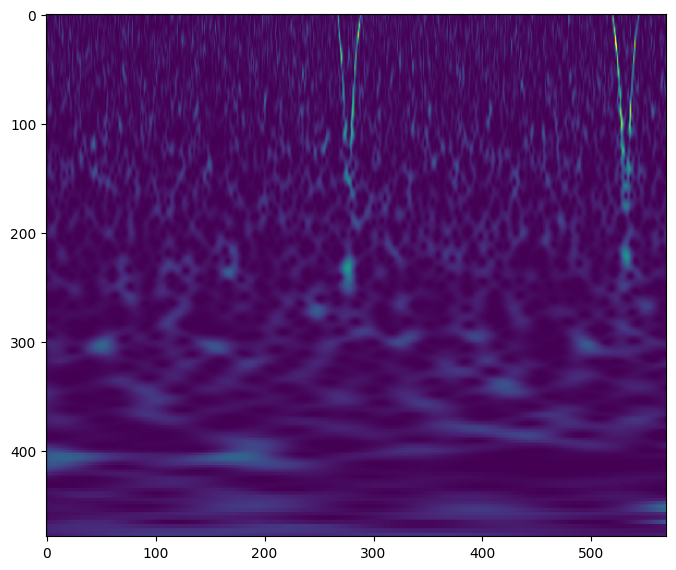

In [ ]:
# visualizing an image for understanding. It helps in taking the decision of resizing the image for further preprocessing

plt.figure(figsize = (8,8))
image = plt.imread("/content/train/train/Whistle/L1_eZzhGjK5ck_spectrogram_2.0.png")
plt.imshow(image)

(384, 384, 4)


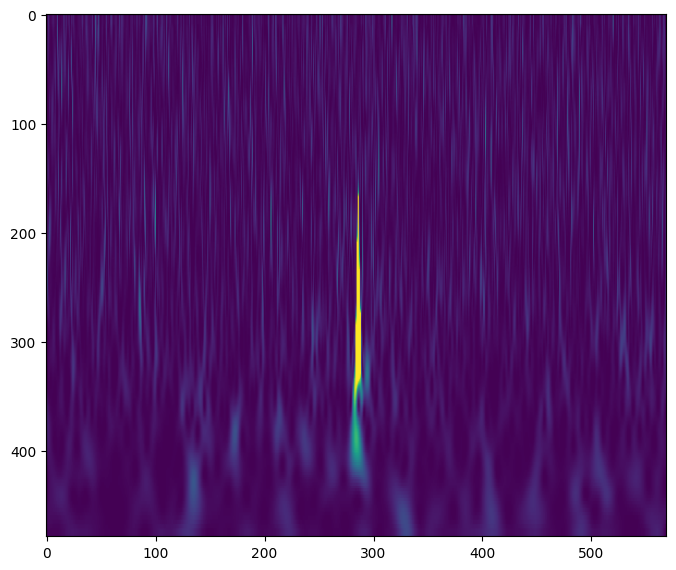

In [ ]:
'''
Usually powers of 2 are selected as a number to resize the images, eg. 128, 256, 512.
In this case 512 would be larger and 256 would be smaller and could lead to loss of data. Hence 256 + 128 = 384 is selected as a number to reshape the image into.
'''
new_image = cv2.resize(image, (384, 384))
print(new_image.shape)
plt.figure(figsize = (8,8))
image = plt.imread("/content/train/train/Blip/H1_017BiNepgE_spectrogram_4.0.png")
plt.imshow(image)

In [ ]:
'''
There are 3 distinct main folders - train, validation and test.
Creating the training set.
Images are in grayscale format, batch size is 64, all images are reshaped into (384 X 384 X 1).
Shuffling is set to true as the images are segregated into folders for each category.
'''
train_dir_path = '/content/train/train'               # defining the main dir path

training_set = tf.keras.utils.image_dataset_from_directory(
    train_dir_path,
    labels = 'inferred',
    label_mode='int',
    color_mode = 'grayscale',
    batch_size = 64,
    image_size = (384,384),
    shuffle = True,
)

Found 22348 files belonging to 22 classes.


In [ ]:
# similar to training set, validation set is created.
val_dir_path = '/content/validation/validation'

validation_set = tf.keras.utils.image_dataset_from_directory(
    val_dir_path,
    labels = 'inferred',
    label_mode='int',
    color_mode = 'grayscale',
    batch_size = 64,
    image_size = (384,384),
    shuffle = True,
)

Found 4800 files belonging to 22 classes.


In [ ]:
# function to normalize the image pixels between 0 and 1.

def normalization(image, label):
    image = tf.cast(image, tf.float16)/255.0
    return image, label

training_set = training_set.map(normalization)
validation_set = validation_set.map(normalization)

In [ ]:
training_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
validation_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# code to convert categories into labels (numerical)
# calculating class weights based on the number of images present in each folder and total number of images
category_to_index = {category: i for i, category in enumerate(categories)}
numerical_categories = category_to_index.values()
sum_images = sum(total_imgs)
class_weights = {label: sum_images / (count * len(numerical_categories))
                   for label, count in zip(numerical_categories, total_imgs)}
print(class_weights)

{0: 1.2209353146853146, 1: 2.373406966864911, 2: 6.194013303769402, 3: 4.304314329738059, 4: 1.1089718142119889, 5: 0.8036536248561565, 6: 0.8062049062049063, 7: 0.8245277449822904, 8: 1.3727272727272728, 9: 6.194013303769402, 10: 0.7034751951649458, 11: 0.8087724377533295, 12: 4.455342902711323, 13: 3.478829389788294, 14: 0.19933637790780648, 15: 8.75705329153605, 16: 1.0715381664748753, 17: 0.8942061459667093, 18: 0.5811316829623466, 19: 13.366028708133971, 20: 0.5099488864549105, 21: 1.3023310023310024}


In [ ]:
'''
Defining the architecture of the neural network.
All the layers except output layer use relu activation function. The output layer uses softmax as there are 22 categories.
'''

num_classes = len(categories)

model = Sequential([
    Conv2D(filters=32, kernel_size=(5,5), input_shape=(384,384,1), activation='relu'),
    MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    Conv2D(filters=64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# As there are multiple classes, sparse categorical cross entropy is the perfect loss function.
# Adam is one of the optimal optimizers.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# input shape is defined as (384, 384, 1)

model.build(input_shape = (384,384,1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 380, 380, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 190, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 190, 190, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 186, 186, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 93, 93, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 93, 93, 64)        0

In [ ]:
# early stopping definition
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.005,
    restore_best_weights=True
)

In [ ]:
# epochs set to 5 as model performance is excellent
history = model.fit(
    training_set,
    epochs=5,
    validation_data=validation_set,
    callbacks=[early_stopping_callback],
    class_weight=class_weights
)

Epoch 1/5
350/350 [==============================] - 277s 737ms/step - loss: 2.4993 - accuracy: 0.6572 - val_loss: 0.5515 - val_accuracy: 0.8490
Epoch 2/5
350/350 [==============================] - 247s 695ms/step - loss: 0.6433 - accuracy: 0.8817 - val_loss: 0.3999 - val_accuracy: 0.9142
Epoch 3/5
350/350 [==============================] - 248s 699ms/step - loss: 0.4489 - accuracy: 0.9273 - val_loss: 0.4256 - val_accuracy: 0.9146
Epoch 4/5
350/350 [==============================] - 250s 701ms/step - loss: 0.2669 - accuracy: 0.9564 - val_loss: 0.3931 - val_accuracy: 0.9244
Epoch 5/5
350/350 [==============================] - 249s 703ms/step - loss: 0.1778 - accuracy: 0.9701 - val_loss: 0.3741 - val_accuracy: 0.9292


In [ ]:
# code to save model as a h5 file. This helps to save retraining time. It can also be used to build applications without involving training the model.

model.save("/content/model_64_5.h5")
print("Model Saved")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Saved


In [ ]:
# prints historical data of loss and accuracy for train and validation sets in every epoch.

loss_vals = np.round(history.history["loss"],4)
loss_vals = list(loss_vals)
val_loss_vals = np.round(history.history["val_loss"],4)
val_loss_vals = list(val_loss_vals)
acc_vals = np.round(history.history["accuracy"],4)
acc_vals = list(acc_vals)
val_acc_vals = np.round(history.history["val_accuracy"],4)
val_acc_vals = list(val_acc_vals)
print(loss_vals, acc_vals, val_loss_vals, val_acc_vals)

[1.8617, 0.4674, 0.256, 0.1761, 0.1759] [0.7143, 0.9002, 0.9406, 0.9571, 0.9586] [0.4887, 0.3845, 0.3571, 0.4154, 0.3858] [0.8669, 0.9106, 0.9196, 0.9154, 0.9154]


<Figure size 800x800 with 0 Axes>

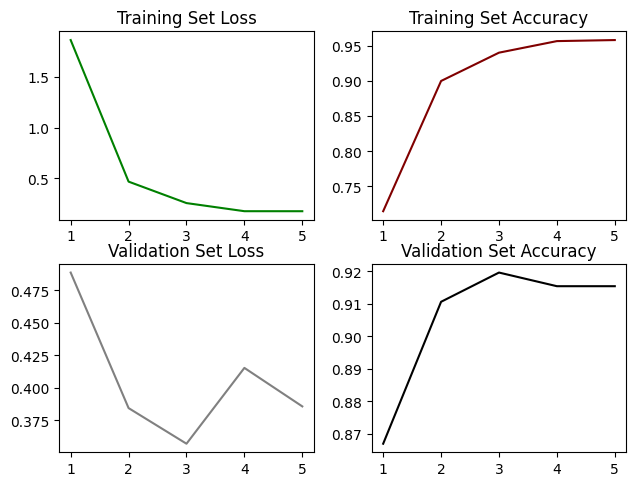

In [ ]:
'''
Plotting accuracy and loss behavior over multiple epochs.
'''
epochs = []
for i in range(1,6):
    epochs.append(i)
plt.figure(figsize = (8,8))
fig, axs = plt.subplots(2,2)
fig.tight_layout()
axs[0,0].plot(epochs, loss_vals, color = 'green')
axs[0,1].plot(epochs, acc_vals, color = 'maroon')
axs[1,0].plot(epochs, val_loss_vals, color = 'gray')
axs[1,1].plot(epochs, val_acc_vals, color = 'k')
axs[0,0].set_title("Training Set Loss")
axs[0,1].set_title("Training Set Accuracy")
axs[1,0].set_title("Validation Set Loss")
axs[1,1].set_title("Validation Set Accuracy")
plt.show()

In [ ]:
# creating the test set in similar way to the training set
test_dir_path = '/content/test/test'

test_set = tf.keras.utils.image_dataset_from_directory(
    test_dir_path,
    labels = 'inferred',
    label_mode='int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (384,384),
    shuffle = True,
)

Found 4720 files belonging to 22 classes.


Working with Test Set

In [ ]:
test_target = test_set.class_names
print(test_target)

['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']


In [ ]:
# perform normalization on test set that is to bring the pixel values between 0 and 1
test_set = test_set.map(normalization)
test_set

<_MapDataset element_spec=(TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float16, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Initialize empty lists to store true labels and predicted labels
y_test = []
y_pred = []

# Iterate over batches of test data and collect true and predicted labels
for images, labels in test_set:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_test.extend(labels.numpy())

# Convert lists to numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

In [ ]:
print(y_test, y_pred)

[3 5 5 ... 8 3 3] [ 3  5  5 ...  8  3 15]


In [ ]:
y_pred.shape

(4720,)

In [ ]:
y_test.shape

(4720,)

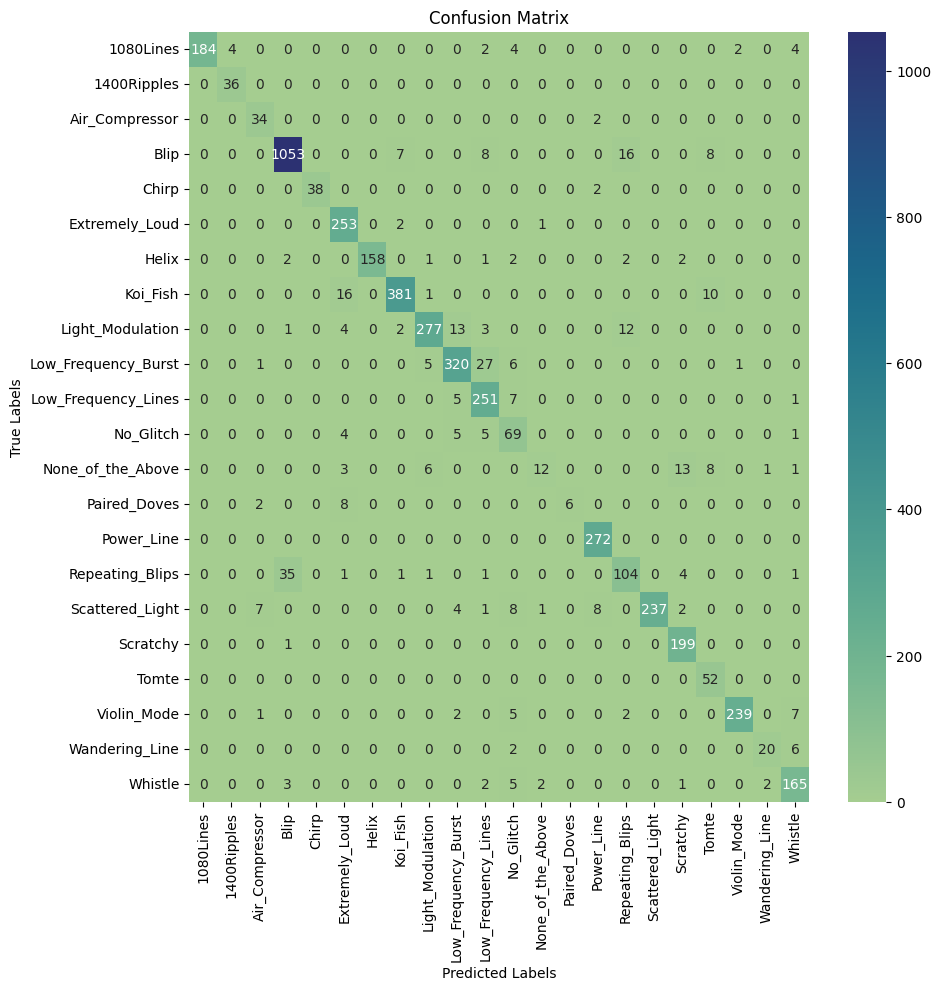

In [ ]:
# plotting the large confusion matrix as a heatmap to understand the precision and recall values.
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', xticklabels=test_target, yticklabels=test_target)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)  # Rotate x-axis labels if they are too long
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# classification report
report = classification_report(y_test, y_pred, target_names=test_target)
print("Classification Report:")
print(report)

Classification Report:
                     precision    recall  f1-score   support

          1080Lines       1.00      0.92      0.96       200
        1400Ripples       0.90      1.00      0.95        36
     Air_Compressor       0.76      0.94      0.84        36
               Blip       0.96      0.96      0.96      1092
              Chirp       1.00      0.95      0.97        40
     Extremely_Loud       0.88      0.99      0.93       256
              Helix       1.00      0.94      0.97       168
           Koi_Fish       0.97      0.93      0.95       408
   Light_Modulation       0.95      0.89      0.92       312
Low_Frequency_Burst       0.92      0.89      0.90       360
Low_Frequency_Lines       0.83      0.95      0.89       264
          No_Glitch       0.64      0.82      0.72        84
  None_of_the_Above       0.75      0.27      0.40        44
       Paired_Doves       1.00      0.38      0.55        16
         Power_Line       0.96      1.00      0.98       272
